In [1]:
import cv2
import random

import matplotlib.pyplot as plt


def randomized_grid(h, w, scale):
    if ( scale==0):
        scale=min(h,w)//3
    assert (scale > 0)

    r = scale//2

    grid = []
    for i in range(0, h, scale):
        for j in range(0, w, scale):
            y = random.randint(-r, r) + i
            x = random.randint(-r, r) + j

            grid.append((y % h, x % w))

    random.shuffle(grid)
    return grid
    
#type(grid)
#len(grid)
#type(grid[0])
def plot_grid(grid):
    x_val = [x[0] for x in grid]
    y_val = [x[1] for x in grid]
        
    plt.scatter(x_val,y_val)
    plt.show()


In [2]:

import random
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline


def get_random_color(pastel_factor = 0.5):
    return [(x+pastel_factor)/(1.0+pastel_factor) for x in [random.uniform(0,1.0) for i in [1,2,3]]]

def color_distance(c1,c2):
    return sum([abs(x[0]-x[1]) for x in zip(c1,c2)])

def generate_new_color(existing_colors,pastel_factor = 0.5):
    max_distance = None
    best_color = None
    for i in range(0,100):
        color = get_random_color(pastel_factor = pastel_factor)
        if not existing_colors:
            return color
        best_distance = min([color_distance(color,c) for c in existing_colors])
        if not max_distance or best_distance > max_distance:
            max_distance = best_distance
            best_color = color
    return best_color

def generate_palette(n_colors,pastel_factor=0.5):
    palette_color = []

    for i in range(0,n_colors):
        palette_color.append(generate_new_color(palette_color,pastel_factor = pastel_factor))
       # print(palette_color)
    return palette_color  


In [21]:
#db of  brush strokes images in list

import os

# folder path
dir_path = './data/brush_strokes/00_bs_db/'

# list to store files
lst_bs = []

# Iterate directory
for path in os.listdir(dir_path):
    # check if current path is a file
    if os.path.isfile(os.path.join(dir_path, path)):
        lst_bs.append(path)
#print(lst_bs, len(lst_bs))

In [27]:
from PIL import Image


paint_path = './data/brush_strokes/02_paintings/'

def paint_generator (paint_idx):   
    
#random parameters

    lst_frame_sizes=[(600,600),(400,600),(600,400),(800,400),(400,800),(600,200), (200,600),(400,400),(200,200)]


    #______________frame selection from the list
    frame_size=random.choice(lst_frame_sizes)

    #print("Randomly selected frame size:",frame_size)

    bs_centers = randomized_grid(h=frame_size[0], w=frame_size[1],scale=100) # valorar introducir la scale en un random limitado
    
    plt.axis([0, frame_size[0],0, frame_size[1]])    
    plt.gca().set_aspect('equal', adjustable='box')
    
    plot_grid (grid=bs_centers)
    plt.show()

    #print('Num de brush strokes {}. Donde las coordenadas de los centroides{}:'.format(len(bs_centers),bs_centers))


    #______________elegir aleatoriamente n=len(bs_centers) centroides donde se van a situar los bs, selección de bs
    bs_select=random.sample(lst_bs, len(bs_centers))
    #print("brush strokes seleccionados de la db de bs:", bs_select)

    #______________ seleccionar un angulo para girar la figura [0,360]
    lst_degrees=[x for x in range(360)]
    degree=random.sample(lst_degrees, len(bs_centers))
    #print("grados de giro para los bs:", degree)

    #______________añadir un cambio en el tamaño del bs en base a un %. Rango elegido :de -30 a 30
    lst_pct=[(x) for x in range(100,250)]
    lst_scale_percent=random.sample(lst_pct, len(bs_centers))
    #print("escala de tamaño a aplicar en %:", lst_scale_percent)

    #______________colors
    palette = generate_palette(len(bs_centers),pastel_factor=0.5)
    palette_array = np.array(palette)[np.newaxis, :, :]
    plt.imshow(palette_array)
    plt.axis('off')
    plt.show()
    lst_colors=palette_array.tolist()
    #print('Array con los rgb de la paleta seleccionada {}.'.format(lst_colors))
    
    
#painting

    #generating the frame from frame_size
    blank_image = np.zeros((frame_size[0],frame_size[1],3), np.uint8)
    #adding bs's en bs_centers, en el color de la paleta
    #[0]
    lst_imag=[]

    for k in range (len(bs_centers)):

        bs=bs_select[k]
        bs_xy=bs_centers[k]
        bs_color=lst_colors[0][k]
        bs_scale=lst_scale_percent[k]
        bs_angle=degree[k]

        #print ("\n figura bs:",bs,"\n coord:",bs_xy,"\n color:",bs_color,'\n scale:',bs_scale,"\n angle:",bs_angle )
        #blank_image[bs_xy[0],bs_xy[1]]=bs_color

        #rotation
        bs_k_im=Image.open(dir_path + bs)
        rotated=bs_k_im.rotate(bs_angle, expand=True)
        bs_k = np.asarray(rotated)

        #resize
        width = int(bs_k.shape[1] * (1 + bs_scale / 100))
        height = int(bs_k.shape[0] * (1 +  bs_scale / 100))
        #print(bs_k.shape[0],bs_k.shape[1])
        bs_k = cv2.resize(bs_k, (width, height))


        #centramos el bs en el punto donde tenemos que colocarlo
        bs_center=(int(bs_k.shape[0] /2) , int(bs_k.shape[1] /2))
        adjust=(bs_xy[0]-bs_center[0],bs_xy[1]-bs_center[1])

        rgb_tresh=200
        (x,y) = np.where((bs_k[:,:, 0] > rgb_tresh) & (bs_k[ :,:, 1] > rgb_tresh) & (bs_k[:, :, 2] >  rgb_tresh))
        (x,y) = (x + adjust[0], y + adjust[1] )
        
        
        array_2d = np.vstack(([x.T], [y.T])).T
        array_2d = np.where(array_2d > 0  )
        #array_2d=np.where((array_2d[:] >= 0) & (array_2d[ :,:, 1] >= 0) & (array_2d[:, :, 2] >= 0))

        #generamos un array de imagenes donde layer=index_array =orden_de_pintura =k 
        imag_k = np.ones((frame_size[0],frame_size[1],3),np.float64)  

        x2= x[(x>0) & (y>0) & (x <frame_size[0]) & (y< frame_size[1])]
        y2= y[(x>0) & (y>0) & (x <frame_size[0]) & (y< frame_size[1])]
        x=x2
        y=y2
        
        imag_k[x,y] = lst_colors[0][k]

        lst_imag.append(imag_k)
        print(imag_k.shape, lst_colors[0][k])      
              
        
        plt.scatter(x,y,color=lst_colors[0][k],s=1, alpha=0.5)
      
        

        #plt.show()
        #bs_k_im
    
    
    plt.axis([0, frame_size[0],0, frame_size[1]])
    
    plt.gca().set_aspect('equal', adjustable='box')
    plt.axis('off')
    plt.savefig(paint_path + "paint_" + ("0"*4 + str(paint_idx))[-5:]  + ".png")
    plt.axis('on')
    plt.show()
    
    
    #plt.xlim(0, frame_size[0]) 
    #plt.ylim(0, frame_size[1])
    return lst_imag
    
    

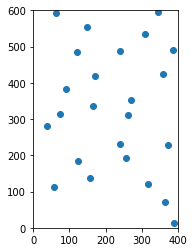

(400, 600, 3) [0.9355479487515955, 0.8012562118994667, 0.6861921333685131]
(400, 600, 3) [0.41521724561678347, 0.3358046138870328, 0.3692282312988697]
(400, 600, 3) [0.42519338401597023, 0.6530307184958046, 0.967376063442703]
(400, 600, 3) [0.5316535095213591, 0.9370476619467403, 0.4298991798909244]
(400, 600, 3) [0.9922217609493864, 0.3622066891411793, 0.47547895241707794]
(400, 600, 3) [0.641773896847894, 0.49436003079167845, 0.6547397468317878]
(400, 600, 3) [0.8945587264138471, 0.40629240572090847, 0.9367522920654302]
(400, 600, 3) [0.3619444986985636, 0.9527981223495933, 0.7979466293456271]
(400, 600, 3) [0.8766344274393699, 0.6663758157405436, 0.356694072655733]
(400, 600, 3) [0.8469493835572081, 0.9857543095350403, 0.9190036556328748]
(400, 600, 3) [0.35771685186190294, 0.6188286159622024, 0.6125720076909024]
(400, 600, 3) [0.9703518285433259, 0.9702410878094953, 0.39271646366598273]
(400, 600, 3) [0.7959930975517594, 0.6181195647725266, 0.8069962970659029]
(400, 600, 3) [0.5243

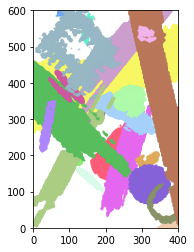

In [32]:
lst_imag=paint_generator(99)

número de trazas:24


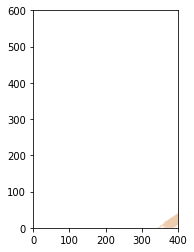

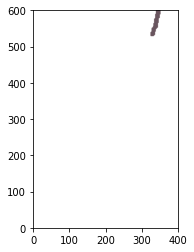

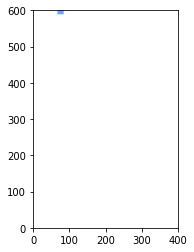

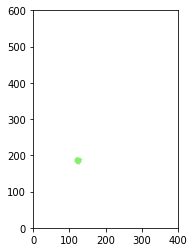

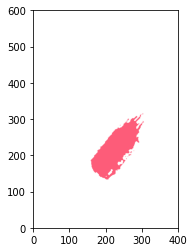

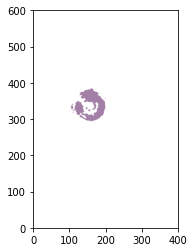

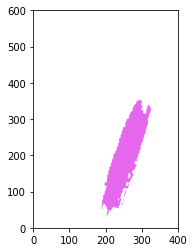

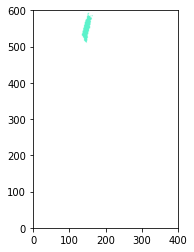

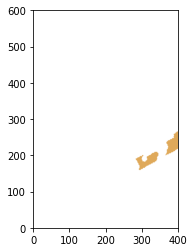

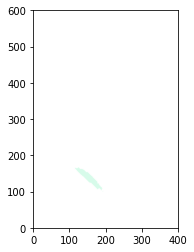

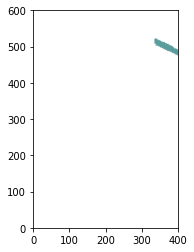

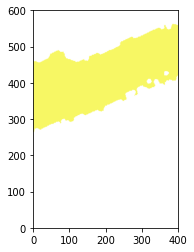

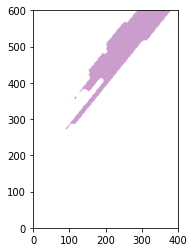

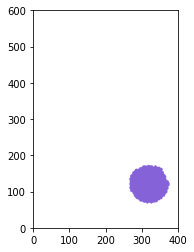

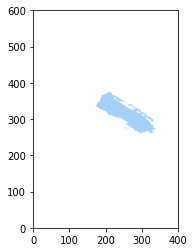

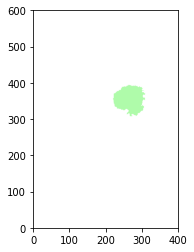

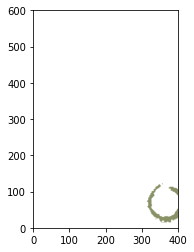

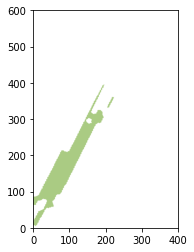

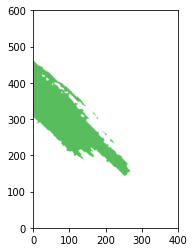

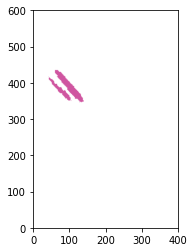

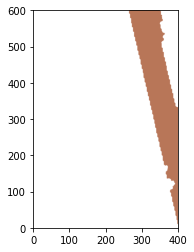

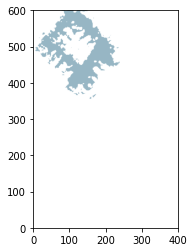

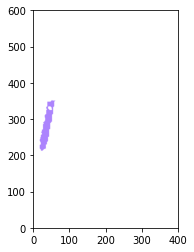

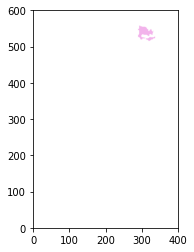

In [33]:
print("número de trazas:{0}".format(len(lst_imag)))
for k in range(len(lst_imag)):
    imag_k_t= lst_imag[k].transpose(1, 0, 2)
    #print(imag_k_t.shape)
    plt.axis([0, lst_imag[k].shape[0],0, lst_imag[k].shape[1]])
    plt.imshow(imag_k_t)
    plt.show()

In [34]:
lst_imag_deep=[]
for k in range(len(lst_imag)):
    imag_k_t= lst_imag[k]
    print('image',k)
    
    layer_found=0    
    
    if k==0:               
        lst_imag_deep.append(imag_k_t) 
        layer_found=1
        print('layer 0',len(lst_imag_deep)-1)
    else:
        max_layer_id=max(len(lst_imag_deep),0)
        for k_i in range(max_layer_id, 0 , -1):
            print('k_i=',k_i)
            imag_cmp=lst_imag_deep[k_i-1]

            #comparación la sum(M1[ones to zeros]+M2[ones to zeros]  zero to ones) <> product(M1+M2 ones)
            sum_acumM_newM0=np.where(imag_cmp==1,0,imag_cmp) + np.where(imag_k_t==1,0,imag_k_t)
            sum_acumM_newM= np.where(sum_acumM_newM0==0,1,sum_acumM_newM0)            
            product_acumM_newM=np.multiply(imag_cmp,imag_k_t)

            if (sum_acumM_newM==product_acumM_newM).all(): #no overlaping, if not in layer 0 then go to next layer
                if k_i-1 ==0:
                    lst_imag_deep[k_i-1]= sum_acumM_newM #in first layer,include the item in this layer
                    layer_found=1
                    print('layer k_i',k_i-1)
                    break
                else:
                    pass                
            else: #overlaping
                if k_i ==len(lst_imag_deep): #last layer, add a new one
                    lst_imag_deep.append(imag_k_t) 
                    layer_found=1
                    print('layer last1',len(lst_imag_deep)-1)
                    break
                else:#include the item in the layer +1                    
                    layer_1=np.multiply(lst_imag_deep[k_i + 1 - 1 ],imag_k_t)
                    lst_imag_deep[k_i + 1 - 1 ]= layer_1 #change layer for a new one with the new element 
                    layer_found=1
                    print('layer k_i+1 -1 ',k_i+1 -1 )
                    break
                pass   
            
    if layer_found==0: # overlap
        lst_imag_deep.append(imag_k_t) 
        print('layer last2',len(lst_imag_deep)-1)
    else:
        pass
    


image 0
layer 0 0
image 1
k_i= 1
layer k_i 0
image 2
k_i= 1
layer k_i 0
image 3
k_i= 1
layer k_i 0
image 4
k_i= 1
layer k_i 0
image 5
k_i= 1
layer k_i 0
image 6
k_i= 1
layer last1 1
image 7
k_i= 2
k_i= 1
layer k_i 0
image 8
k_i= 2
layer last1 2
image 9
k_i= 3
k_i= 2
k_i= 1
layer k_i 0
image 10
k_i= 3
k_i= 2
k_i= 1
layer k_i 0
image 11
k_i= 3
k_i= 2
k_i= 1
layer k_i+1 -1  1
image 12
k_i= 3
k_i= 2
layer k_i+1 -1  2
image 13
k_i= 3
layer last1 3
image 14
k_i= 4
k_i= 3
k_i= 2
layer k_i+1 -1  2
image 15
k_i= 4
k_i= 3
layer k_i+1 -1  3
image 16
k_i= 4
layer last1 4
image 17
k_i= 5
k_i= 4
layer k_i+1 -1  4
image 18
k_i= 5
layer last1 5
image 19
k_i= 6
layer last1 6
image 20
k_i= 7
k_i= 6
k_i= 5
layer k_i+1 -1  5
image 21
k_i= 7
layer last1 7
image 22
k_i= 8
k_i= 7
k_i= 6
layer k_i+1 -1  6
image 23
k_i= 8
k_i= 7
k_i= 6
layer k_i+1 -1  6


número de capas: 8


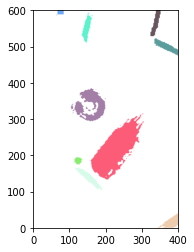

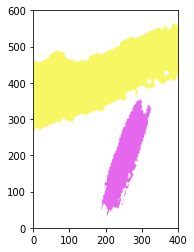

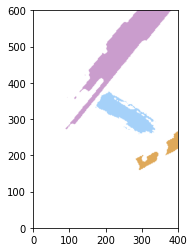

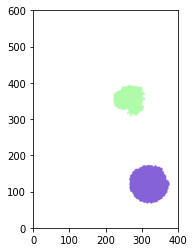

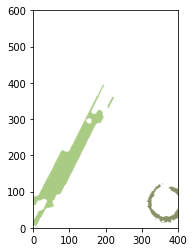

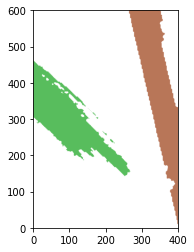

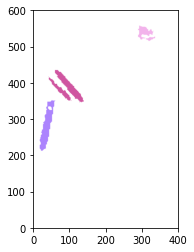

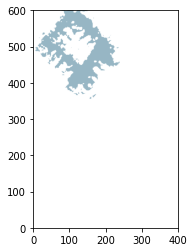

In [35]:
print("número de capas:",len(lst_imag_deep))
for k in range(len(lst_imag_deep)):
    imag_k_t= lst_imag_deep[k].transpose(1, 0, 2)
    #print(imag_k_t.shape)
    plt.axis([0, lst_imag_deep[k].shape[0],0, lst_imag_deep[k].shape[1]])
    plt.imshow(imag_k_t)
    plt.show()
    



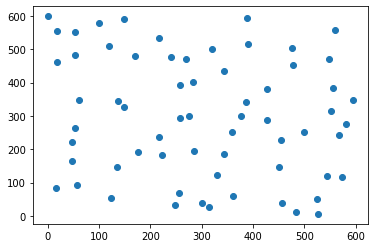

In [16]:
#test unitario 1/2________________________

paint_idx=99

lst_frame_sizes=[(600,600),(400,600),(600,400),(800,400),(400,800),(600,200), (200,600)]


#______________frame selection from the list
frame_size=random.choice(lst_frame_sizes)

#print("Randomly selected frame size:",frame_size)

bs_centers = randomized_grid(h=frame_size[0], w=frame_size[1],scale=75) # valorar introducir la scale en un random limitado
plot_grid (grid=bs_centers)
plt.show()

#print('Num de brush strokes {}. Donde las coordenadas de los centroides{}:'.format(len(bs_centers),bs_centers))


#______________elegir aleatoriamente n=len(bs_centers) centroides donde se van a situar los bs, selección de bs
bs_select=random.sample(lst_bs, len(bs_centers))
#print("brush strokes seleccionados de la db de bs:", bs_select)

#______________ seleccionar un angulo para girar la figura [0,360]
lst_degrees=[x for x in range(360)]
degree=random.sample(lst_degrees, len(bs_centers))
#print("grados de giro para los bs:", degree)

#______________añadir un cambio en el tamaño del bs en base a un %. Rango elegido :de -30 a 30
lst_pct=[(x) for x in range(100,250)]
lst_scale_percent=random.sample(lst_pct, len(bs_centers))
#print("escala de tamaño a aplicar en %:", lst_scale_percent)

#______________colors
palette = generate_palette(len(bs_centers),pastel_factor=0.5)
palette_array = np.array(palette)[np.newaxis, :, :]
plt.imshow(palette_array)
plt.axis('off')
plt.show()
lst_colors=palette_array.tolist()
   
    

(600, 600, 3) [0.9850948655378989, 0.7916656011869595, 0.9866780340611679]


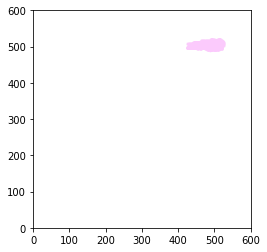

(600, 600, 3)


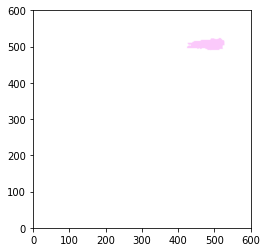

In [17]:
#test_unitario 2/2______________________________________

%matplotlib inline
lst_imag=[]
k=2
bs=bs_select[k]
bs_xy=bs_centers[k]
bs_color=lst_colors[0][k]
bs_scale=lst_scale_percent[k]
bs_angle=degree[k]

#print ("\n figura bs:",bs,"\n coord:",bs_xy,"\n color:",bs_color,'\n scale:',bs_scale,"\n angle:",bs_angle )
#blank_image[bs_xy[0],bs_xy[1]]=bs_color

#rotation
bs_k_im=Image.open(dir_path + bs)
rotated=bs_k_im.rotate(bs_angle, expand=True)
bs_k = np.asarray(rotated)

#resize
width = int(bs_k.shape[1] * (1 + bs_scale / 100))
height = int(bs_k.shape[0] * (1 +  bs_scale / 100))
#print(bs_k.shape[0],bs_k.shape[1])
bs_k = cv2.resize(bs_k, (width, height))


#centramos el bs en el punto donde tenemos que colocarlo
bs_center=(int(bs_k.shape[0] /2) , int(bs_k.shape[1] /2))
adjust=(bs_xy[0]-bs_center[0],bs_xy[1]-bs_center[1])

rgb_tresh=200
(x,y) = np.where((bs_k[:,:, 0] > rgb_tresh) & (bs_k[ :,:, 1] > rgb_tresh) & (bs_k[:, :, 2] >  rgb_tresh))
(x,y) = (x + adjust[0], y + adjust[1] )


array_2d = np.vstack(([x.T], [y.T])).T
array_2d = np.where(array_2d > 0  )
#array_2d=np.where((array_2d[:] >= 0) & (array_2d[ :,:, 1] >= 0) & (array_2d[:, :, 2] >= 0))

#generamos un array de imagenes donde layer=index_array =orden_de_pintura =k 
imag_k = np.ones((frame_size[0],frame_size[1],3),np.float64)  

x2= x[(y< frame_size[1]) & (x <frame_size[0]) & (x>0) & (y>0)]
y2= y[(y< frame_size[1]) & (x <frame_size[0]) & (x>0) & (y>0) ]
x=x2
y=y2
imag_k[x,y] = lst_colors[0][k]

lst_imag.append(imag_k)
print(imag_k.shape, lst_colors[0][k])


plt.axis([0, frame_size[0],0, frame_size[1]])
plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(x,y,color=[lst_colors[0][k]],s=1, alpha=.5)
plt.show()


imag_k_t= imag_k.transpose(1, 0, 2)
print(imag_k_t.shape)
plt.axis([0, frame_size[0],0, frame_size[1]])
plt.imshow(imag_k_t)

# Registramos deepness
___

cada dibujo tiene una profundidad siguiendo las hipótesis siguientes, y sabiendo que están ordenadas cronológicamente dentro de la lista;
* si dos trazas no se cruzan, pertenecen a la misma capa. Ante la duda, asignar mínima capa.
* cuando hay cruce se pasa a la capa siguiente
*
*

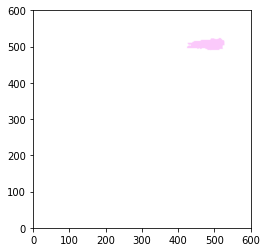

In [18]:
for k in range(len(lst_imag)):
    imag_k_t= lst_imag[k].transpose(1, 0, 2)
    #print(imag_k_t.shape)
    plt.axis([0, lst_imag[k].shape[0],0, lst_imag[k].shape[1]])
    plt.imshow(imag_k_t)
    plt.show()

In [223]:
path='./data/'

image = cv2.imread(path + "AH01.jpg")
a = np.asarray(image)